# Forecasting Dish Subscribers Using Gated Recurrent Units (GRUs) - Part 1

In the code below, we develop our underlying models using the methodology defined in the README.

## Setup

* Import packages
* Set parameters
* Define file paths
* Load data from Excel

In [1]:
# Import packages
import numpy as np
import pandas as pd
from sklearn import preprocessing
from keras.layers import Input, GRU, Dense, concatenate, Activation
from keras.models import Model
import datetime
import sys
import random
import matplotlib as mpl
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Set parameters
trainingsize = 80 # Percent of data to use in training set
validation_size = 0 # Validation size for use in Keras' .fit
shuffle = False # shuffles inputs when fitting model
GRUnodes = 64
path = "C:\\Users\\nthor\\Desktop\\Kaggle\\Python\\"
file = "Dish Data.xlsx" # Name of .xlsx file
sheet = "Data" # Name of .xlsx sheet
span = 8 # Time lag for endogeneous variables used in baseline model (in quarters)
horiz = 6 # Steps in the future to predict (in quarters)
yweight = .4 # Weight of RNN based on y only
xyweight = 1 - yweight # Weight of RNN based on x + y
n_epoch = 5000 # set number of epochs
time_increment = 91 # delta_t used to create next series of dat. we're using quarters in our example

In [3]:
# Set random seed
seed = 2017
np.random.seed(seed)

In [4]:
# Load data
loc = path + file

# Open spreadsheet
Excel = pd.ExcelFile(loc)
raw = Excel.parse('Data')

In [5]:
# View data
raw.head()

,#,Year / Quarter,Pay-TV Customers Acq. (in hundred thousands),Cum. Customers Acq.,Q1 Impact,Q2 Impact,Q3 Impact,Recession,Sub. Promotion Subsidies,Recreation services,US GDP,Product Releases
0,1,1996Q1,2,2,1,0,0,0,33591,189.8,0.0461,0
1,2,1996Q2,29,31,0,1,0,0,33591,193.6,0.0600,0
2,3,1996Q3,70,101,0,0,1,0,33591,198.4,0.0587,0
3,4,1996Q4,104,205,0,0,0,0,33591,200.6,0.0625,0
4,5,1997Q1,133,338,1,0,0,0,145061,204.2,0.0645,0


In [6]:
# Load variables (convert to float64 to pre-empt modeling issues)
lastrow = len(raw) # Adjust for Zero Index

t = raw.iloc[0:lastrow, 0].astype('float64') # Time-steps (1,2, etc.)
dates = raw.iloc[0:lastrow, 1] # Quarter dates (e.g., 1996Q1)
newcust = raw.iloc[0:lastrow, 2].astype('float64') # Number of new Pay-TV customers
cumcust = raw.iloc[0:lastrow, 3].astype('float64') # Cumulative number of Pay-TV customers
q1 = raw.iloc[0:lastrow, 4].astype('float64') # Indicator for Q1 (created to capture seasonality effects)
q2 = raw.iloc[0:lastrow, 5].astype('float64') # Indicator for Q1 (created to capture seasonality effects)
q3 = raw.iloc[0:lastrow, 6].astype('float64') # Indicator for Q1 (created to capture seasonality effects)
recession = raw.iloc[0:lastrow, 7].astype('float64') # Indicator for the 2008 recession
subsidies = raw.iloc[0:lastrow, 8].astype('float64') # Dish promotional subsidies ($)
rec_spend = raw.iloc[0:lastrow, 9].astype('float64') # US Census avg. recreational spend by household
GDP = raw.iloc[0:lastrow, 10].astype('float64') # US GDP (%)
newprod = raw.iloc[0:lastrow, 11].astype('float64') # Indicator for introduction of SlingTV (low cost "cut the cord" option that likely led to a spike in subscribers)

## Data Transformation & Model Preparation

* Log-transform variables
* Define x and y variables
* Normalize metrics
* Define lag variables using user-defined 'span' variable

In [7]:
# Log-transform large variables to minimize outlier effects
ln_rec_spend = np.log(rec_spend)
ln_subsidies = np.log(subsidies)

In [8]:
# Define x and y variables (named as '_1' to denote pre-normalized values)
x_1 = pd.concat([q1, q2, q3, recession, ln_rec_spend, ln_subsidies, newprod], axis = 1)
y_1 = newcust
y_cum = cumcust 

In [9]:
# View x variables
x_1.head()

,Q1 Impact,Q2 Impact,Q3 Impact,Recession,Recreation services,Sub. Promotion Subsidies,Product Releases
0,1.0,0.0,0.0,0.0,5.245971,10.422013,0.0
1,0.0,1.0,0.0,0.0,5.265794,10.422013,0.0
2,0.0,0.0,1.0,0.0,5.290285,10.422013,0.0
3,0.0,0.0,0.0,0.0,5.301313,10.422013,0.0
4,1.0,0.0,0.0,0.0,5.319100,11.884910,0.0


In [10]:
# Normalize metrics
scaler_x = preprocessing.MinMaxScaler(feature_range = (0,1)) # Create scaler
scaler_y = preprocessing.MinMaxScaler(feature_range = (0,1))

x = np.array(x_1).reshape((len(x_1), len(x_1.columns))) # Reshape to avoid deprecation warning
x = scaler_x.fit_transform(x) # Transform x elements

y = np.array(y_1).reshape((len(y_1), 1))
y = scaler_y.fit_transform(y)

In [11]:
# Assemble matrices containing samples of x-spans, y-spans, and y-horizons across the available timeline
nsample = len(y) - span - horiz # The number of samples equals the number of observations minus our number of time lag and prediction observations
x_list = [np.expand_dims(np.atleast_2d(x[i:span + i,:]), axis = 0) for i in range(nsample)] # Group observations by our span parameter (2 by default)
x_mat = np.concatenate(x_list, axis = 0) # Concatenate these lists into a single numpy array

# Define y lag period
ylag_list = [np.expand_dims(np.atleast_2d(y[i:span + i, :]), axis = 0) for i in range(nsample)]
ylag_mat = np.concatenate(ylag_list, axis = 0) # Essentially are adding another list level: row to span period (2 by default)

# Define target horizon
y_list = [np.atleast_2d(y[i + span:span + i + horiz, 0]) for i in range(nsample)] # Groups the elements in y by our horizon parameter (i.e., groups 4 together into one list entry)
y_mat = np.concatenate(y_list, axis = 0) # Concatenate all list entries

# Define prediction observations for our span period (default of two span periods)
ilast = nsample # We will later reset nsample to zero, so need to define a new variable
xlast_list = [np.expand_dims(np.atleast_2d(x[ilast:span + ilast,:]), axis = 0)]
xlast_mat = np.concatenate(xlast_list, axis = 0)

ylastlag_list = [np.expand_dims(np.atleast_2d(y[ilast : span + ilast, :]), axis = 0)]
ylastlag_mat = np.concatenate(ylastlag_list, axis = 0)

## Modeling
* Split into test and training
* Develop GRUs and merge layers
* Train the model and fit results
* Generate forecasts

### Split data into test and training

In [12]:
# Define training sets
end = y_mat.shape[0] - 1 # Set the end of our data
learning_end = (end * trainingsize)//100 # Marks end of training set

x_mat_train = x_mat[0:learning_end,] # Define x-variables in training set
y_mat_train = y_mat[0:learning_end,] # Define y-variable in training set
ylag_mat_train = ylag_mat[0:learning_end,] # Define lagging y-variables in training set

In [13]:
# Define test sets
x_mat_test = x_mat[learning_end + 1:end,] # Define x-variables in test set
y_mat_test = y_mat[learning_end + 1:end,] # Contains 15-time spans, with each t+1 from the preceeding span equaling t in the proceeding span 
ylag_mat_test = ylag_mat[learning_end + 1:end,]

In [14]:
# Observe shape of training set to spot-check; we expect the 61 observations from our training set to be grouped into groups of 2 (per span) with 7 elements per observation
x_mat_train.shape

(55, 8, 7)

### Develop GRUs

In [15]:
# Create baseline ("main") GRU network
main_in = Input(shape = (ylag_mat_train.shape[1], 1), dtype = 'float32', name = 'main_in') # Initialize input layer and define data shape
main_gru = GRU(return_sequences = False, activation = 'tanh', units = GRUnodes, recurrent_activation = 'hard_sigmoid')(main_in) # Creates GRU with pre-defined number of nodes using tanh activation function
main_out = Dense(horiz, activation = 'linear', name = 'main_out')(main_gru) # Implements the operation without any activation being applied (i.e., linear)

In [16]:
# Create separate GRU network for both exogenous and endogenous metrics
exo_in = Input(shape = (x_mat_train.shape[1], x_mat_train.shape[2]), dtype = 'float32', name = 'exo_in') # Shapes the input using the number of rows (2) and columns (7) in the array
exo_gru = GRU(return_sequences = False, activation = 'tanh', units = GRUnodes, recurrent_activation = 'hard_sigmoid')(exo_in)
exo_out = Dense(horiz, activation = 'linear', name = 'exo_out')(exo_gru)

In [17]:
# Merge the two GRU layers
merged_layers = concatenate([main_gru, exo_gru])

# Create a dense layer for all merged data elements
combo_out = Dense(horiz, activation = 'sigmoid', name = 'combo_out')(merged_layers)

In [18]:
# Define final model input / output flows; compile parameters
model = Model(inputs = [main_in, exo_in], outputs = [main_out, combo_out]) # Creates two lists of entries: our baseline and our combo
model.compile(optimizer = 'rmsprop', 
              loss = 'mean_squared_error', # Uses MSE as error term (rather than MAPE or alternatives) 
              loss_weights = [yweight, xyweight]) 

### Train and test the final model

In [32]:
# Train the final model
model.fit({'main_in' : ylag_mat_train, 
           'exo_in' : x_mat_train}, 
          {'main_out' : y_mat_train, 
           'combo_out':y_mat_train},
          epochs = n_epoch,
          shuffle = shuffle,
          validation_split = validation_size,
          verbose = False)

In [33]:
# Test the final model
pred = model.predict({'main_in' : ylag_mat_test, 'exo_in' : x_mat_test})

In [34]:
# Forecast y for predictor span that corresponds to horizon for which y(obs) is not known
fcst = model.predict({'main_in' : ylastlag_mat, 'exo_in':xlast_mat})

## Evaluate Error Terms
* Rescale parameters
* Evaluate error terms
* Calculate in-sample (IS) and out-of-sample (OOS) error terms

In [35]:
# Rescale predicted and observed values
# pred is a list of two lists: pred[0][:] = baseline, pred[1][:] = combo
for i in range(0, len(y_mat_test)):
    if i == 0:
        pred_s = scaler_y.inverse_transform(np.array(pred[1][i]).reshape((len(pred[1][i]), 1)))
        y_s = scaler_y.inverse_transform(np.array(y_mat_test[i]).reshape((len(y_mat_test[i]), 1)))
        fcst_s = scaler_y.inverse_transform(np.array(fcst[1][i]).reshape((len(fcst[1][i]), 1)))
    else:
        pred_s = np.concatenate([pred_s, scaler_y.inverse_transform(np.array(pred[1][i]).reshape((len(pred[1][i]), 1)))], axis = 1)
        y_s = np.concatenate([y_s, scaler_y.inverse_transform(np.array(y_mat_test[i]).reshape((len(y_mat_test[i]), 1)))], axis = 1)

In [36]:
# Our prediction output is four groups of 15 observations each (one for each horizon period in our test set) 
pred_s 

array([[ 825.05480957,  690.42944336,  660.96862793,  788.66955566,
         818.14678955,  653.01403809,  730.76019287,  870.43890381,
         840.12921143,  653.23352051,  754.30578613,  875.96734619,
         838.57000732],
       [ 797.60894775,  855.48291016,  661.45678711,  665.85784912,
         808.61663818,  857.78411865,  665.61846924,  723.67254639,
         828.52282715,  872.48736572,  712.70141602,  739.07226562,
         818.69445801],
       [ 873.57611084,  722.49859619,  673.15447998,  718.64355469,
         883.59875488,  780.96069336,  662.67236328,  710.45861816,
         894.16656494,  776.42266846,  738.17657471,  686.72369385,
         889.98468018],
       [ 719.37194824,  724.17669678,  615.87268066,  794.60864258,
         774.95172119,  781.51367188,  662.18615723,  831.03845215,
         782.55749512,  790.02081299,  685.68212891,  835.04852295,
         771.81732178],
       [ 685.4276123 ,  704.34936523,  718.11120605,  637.02600098,
         668.0632324

In [37]:
# Evaluate the model using three MAPE scores: overall loss, baseline loss, and combo loss
MSE_train = model.evaluate({'main_in':ylag_mat_train, 'exo_in':x_mat_train},
                          {'main_out':y_mat_train, 'combo_out' : y_mat_train})

MSE_test = model.evaluate({'main_in':ylag_mat_test, 'exo_in':x_mat_test},
                         {'main_out':y_mat_test, 'combo_out':y_mat_test})

13/13 [==============================] - 0sA: 0s


In [38]:
# View in-sample mean
np.mean(MSE_train)

0.00042108362214287009

In [39]:
# View out-of-sample error terms
np.mean(MSE_test)

0.014586110599339008

In [40]:
# NOTE: This bit of code is an alternative approach to the error code above (no longer necessary)
# Compute error by running through each predicted and observed value
nsample = 0 # Index of sample from testing set chosen to illustrate error
n = 0 # index within the chosen sample
p_cum = np.array([]) # Initiative predicted cumulative distribution of test set (fcst from baseline + combo)
f_cum = np.array([]) # Initiative predicted cumulative distribution of actual forecast (fcst from baseline + combo)
o_cum = np.array([]) # Observed cum. distribution
dsum = 0 # sum of all errors across all steps in this sample

# Initialize matrices
x_axis = np.array([])

while n < horiz: # for as long as n is below our prediction horizon (default = 4)...
    p = pred_s[n, nsample] # pick one prediction from a particular sample / quarter
    f = fcst_s[n, nsample] # pick one forecast from a particular sample / quarter
    o = y_s[n, nsample] # pick one observed count from a particular sample / quarter
    if (n == 0):
        p_cum = np.append(p_cum, y_cum.iloc[learning_end + span] + p) # start by adding the actual value for a given p
        f_cum = np.append(f_cum, y_cum.iloc[learning_end + span + horiz + len(pred)] + f) # add actual value for the given forecast period
        o_cum = np.append(o_cum, y_cum.iloc[learning_end + span] + o) # add observed value for a given o
    elif (n > 0):
        p_cum = np.append(p_cum, p_cum[n-1] + p) # append for new n values
        f_cum = np.append(f_cum, f_cum[n-1] + f)
        o_cum = np.append(o_cum, o_cum[n-1] + o)
    d = round((abs(o - p)), 1) # calculate error term
    dsum = dsum + d
    x_axis = np.append(x_axis, n) # create x-axis
    n = n + 1 # shift to next n
    
# Calculate error terms
avgdiff = dsum / horiz # find the average difference between predictiona nd actual
perc1 = round((avgdiff / o) * 100, 2) # find average difference percentage 
lastdiff = o - p # find the difference between last predicted vs. observed
perc2 = round((lastdiff / o) * 100, 2) # find the percentage difference between last predicted vs. observed

print ("avg diff: ", avgdiff, " (", perc1, "%)")
print ("final diff: ", lastdiff, " (", perc2, "%)")

avg diff:  95.5333333333  ( 15.31 %)
final diff:  -65.1302490234  ( -10.44 %)


In [41]:
# Create finalized set of data
# Select observed and predicted values
nsample = 0
predictions = pred_s[0:horiz, nsample] # Select predictions
observables = y_s[0:horiz, nsample] # Select observed values
forecasts = fcst_s[0:horiz, nsample] # Select forecast values
diff = abs(observables - predictions) / observables * 100 # Perc. difference with respect to observed value
diffcum = abs(o_cum - p_cum) / o_cum * 100 # Perc. difference with respect to observaed value of cum. dist.
dat = dates[span + learning_end + 1 + nsample:span + learning_end + 1 + nsample + horiz]
dat_concat = dates[span + learning_end + 1 + nsample:span + learning_end + 1 + nsample + 2*horiz]

# Include OOS variables
OOS_observables = y_1.iloc[learning_end + horiz + span + 1: learning_end + 2*horiz + span + 1] # Find OOS values for use in calculating error terms
OOS_observables = np.array(OOS_observables, dtype=pd.Series)
OOS_diff = abs(OOS_observables - forecasts) / OOS_observables # Calculate OOS error terms 
OOS_obs_df = pd.DataFrame(data = OOS_observables, index = dat.index + horiz, columns = ['OOS observations'])

# Convert to df
pred_df = pd.DataFrame(data = predictions, index = dat.index, columns = ['predictions'])
obs_df = pd.DataFrame(data = observables, index = dat.index, columns = ['observations'])
f_df = pd.DataFrame(data = forecasts, index = dat.index + horiz, columns = ['forecasts']) 
diff_df = pd.DataFrame(data = diff, index = dat.index, columns = ['diff (%)'])
p_cum_df = pd.DataFrame(data = p_cum, index = dat.index, columns = ['predictions cumul'])
f_cum_df = pd.DataFrame(data = f_cum, index = dat.index + horiz, columns = ['actual fcst cumul'])
o_cum_df = pd.DataFrame(data = o_cum, index = dat.index, columns = ['observations cumul'])
diffcum_df = pd.DataFrame(data = diffcum, index = dat.index, columns = ['diff cumul (%)'])

# Capture error terms
Avg_IS_Error = round(sum(diff_df.iloc[:, 0])/(horiz), 1)
Avg_OOS_Error = round(sum(OOS_diff * 100)/(horiz), 1)

# Report average in-sample error terms
print ("Avg. In-Sample Error: ", Avg_IS_Error, "%")
print ("Avg. Out-of-Sample Error: ", Avg_OOS_Error, "%")

Avg. In-Sample Error:  14.1 %
Avg. Out-of-Sample Error:  9.5 %


## Visualizations
* Concatenate important outputs
* Plot results for visual comparison

In [42]:
# Concatenate dataframes into predictions vs. obsefvations
output_df = pd.concat([dat_concat, pred_df, obs_df, diff_df, p_cum_df, o_cum_df, diffcum_df, f_df, f_cum_df, OOS_obs_df], axis = 1)

# View output
output_df

,Year / Quarter,predictions,observations,diff (%),predictions cumul,observations cumul,diff cumul (%),forecasts,actual fcst cumul,OOS observations
64,2012Q1,825.054810,673.0,22.593582,41251.054810,41099.0,0.369972,NaN,NaN,NaN
65,2012Q2,797.608948,665.0,19.941195,42048.663757,41764.0,0.681601,NaN,NaN,NaN
66,2012Q3,873.576111,739.0,18.210570,42922.239868,42503.0,0.986377,NaN,NaN,NaN
67,2012Q4,719.371948,662.0,8.666457,43641.611816,43165.0,1.104163,NaN,NaN,NaN
68,2013Q1,685.427612,654.0,4.805445,44327.039429,43819.0,1.159404,NaN,NaN,NaN
69,2013Q2,689.130249,624.0,10.437540,45016.169678,44443.0,1.289674,NaN,NaN,NaN
70,2013Q3,NaN,NaN,NaN,NaN,NaN,NaN,776.531860,46607.531860,734
71,2013Q4,NaN,NaN,NaN,NaN,NaN,NaN,722.670471,47330.202332,654
72,2014Q1,NaN,NaN,NaN,NaN,NaN,NaN,709.619812,48039.822144,639
73,2014Q2,NaN,NaN,NaN,NaN,NaN,NaN,699.907471,48739.729614,656


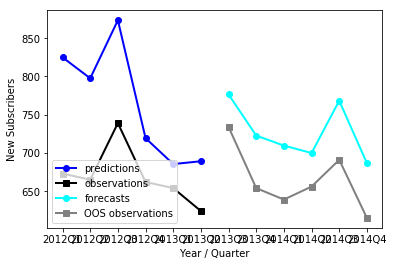

In [43]:
# Visualize outputs
plt.clf()
plt.plot(output_df['predictions'], color = 'blue', lw = 2, marker = 'o')
plt.plot(output_df['observations'], color = 'black', lw = 2, marker = 's')
plt.plot(output_df['forecasts'], color = 'aqua', lw = 2, marker = 'o')
if trainingsize != 100:
    plt.plot(output_df['OOS observations'], color = 'gray', lw = 2, marker = 's')
plt.xticks(output_df.index, output_df['Year / Quarter'])
plt.xlabel('Year / Quarter')
plt.ylabel('New Subscribers')
plt.legend(loc = 'lower left')
plt.show()